# Decision Trees

Debido a que los resultados obtenidos no cubren las necesidades del ejercicio, se plantea el uso de modelos de tipo Ensembles con el fin de dar una solución optima, para esto inicialmente se usara el arbol de decisión como punto de partida.


In [9]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import graphviz #Libreria utilizada para graficar el arbol de decisión
from sklearn.tree import export_graphviz

In [3]:
model = DecisionTreeRegressor(max_depth=2) #Se instancia el modelo con una profundidad inicial de 2

In [4]:
X = pd.read_csv(r'C:\Scripts\Proyectos\Predicción_de_ingresos_peliculas\Data\X_opening_p.csv')
y = X['worldwide_gross']
X = X.drop('worldwide_gross',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [5]:
model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=2)

In [12]:
treedot = export_graphviz(model,out_file=None, feature_names=X.columns) #Se transforma el arbol de decisión a formato graphviz

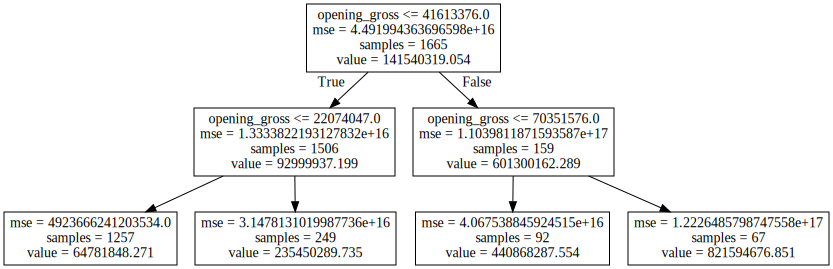

In [11]:
graphviz.Source(treedot)

In [9]:
!pip install --user --upgrade tensorflow

In [8]:
import tensorflow

ModuleNotFoundError: No module named 'tensorflowi'

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping

In [7]:
from keras.models import load_model

In [3]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            0.15.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 2.0.3
anaconda-project                   0.9.1
anyio                              2.2.0
appdirs                            1.4.4
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.5
astropy                            4.2.1
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.6
Babel                              2.9.0
backcall                           0.2.0
backports.functools-lru-cache      1.6.4
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0


In [2]:
#!pip uninstall tensorflow

In [1]:
#!pip install tensorflow==2.2.0

In [1]:
!pip install --user --upgrade scikit-learn
